PERBANDINGAN MODEL PREDIKSI PRODUKSI PADI DI SUMATERA MENGGUNAKAN MACHINE LEARNING

In [39]:
# ============================================================
# 1. IMPORT LIBRARY
# ============================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
# ============================================================
# 2. LOAD DATASET
# ============================================================
df = pd.read_excel("hasilpanensumatra.xlsx")

=== INFO DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.4+ KB
None


=== MISSING VALUES ===
Provinsi          0
Tahun             0
Produksi          0
Luas Panen        0
Curah hujan       0
Kelembapan        0
Suhu rata-rata    0
dtype: int64


=== STATISTIK DESKRIPTIF ===
             Tahun      Produksi     Luas Panen  Curah hujan  Kelembapan  \
count   224.000000  2.240000e+02     224.000000   224.000000  224.000000   
mean   2006.500000  1.679701e+06  374349.

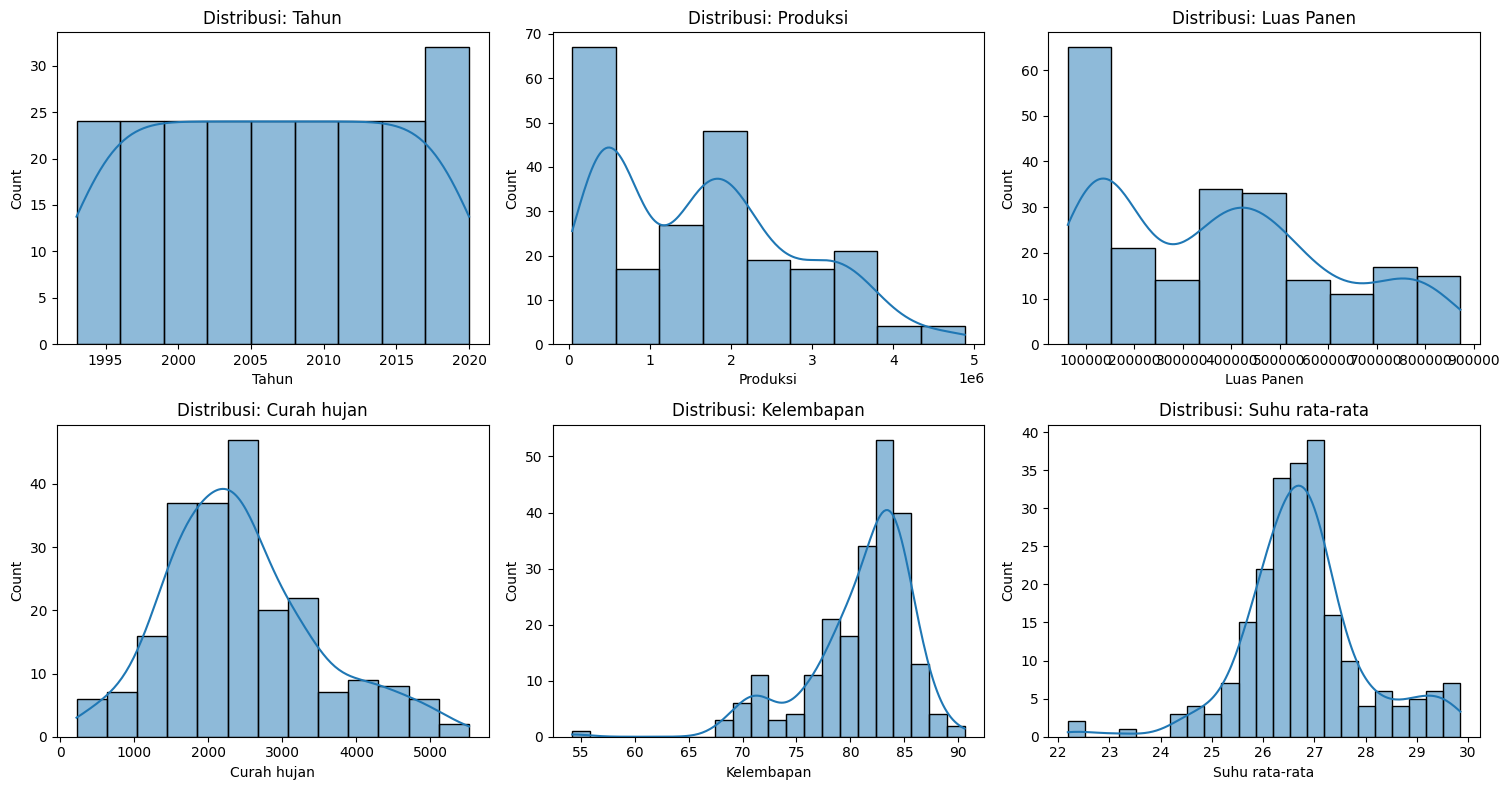

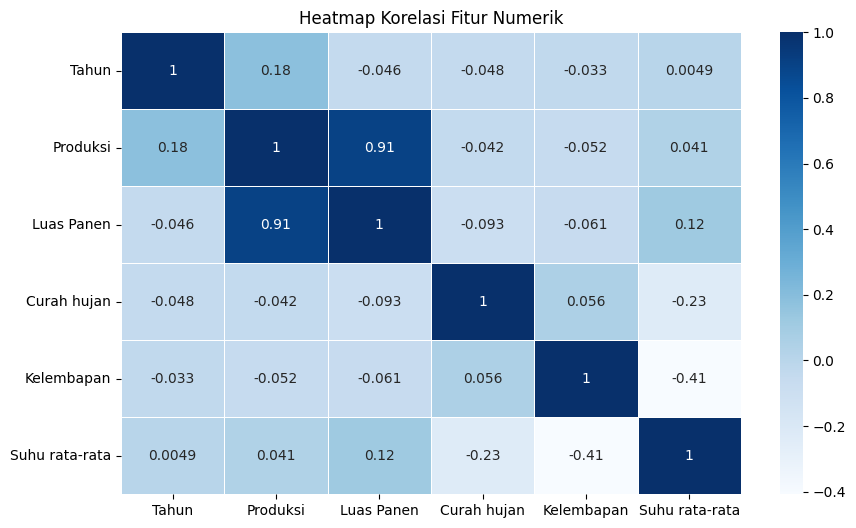

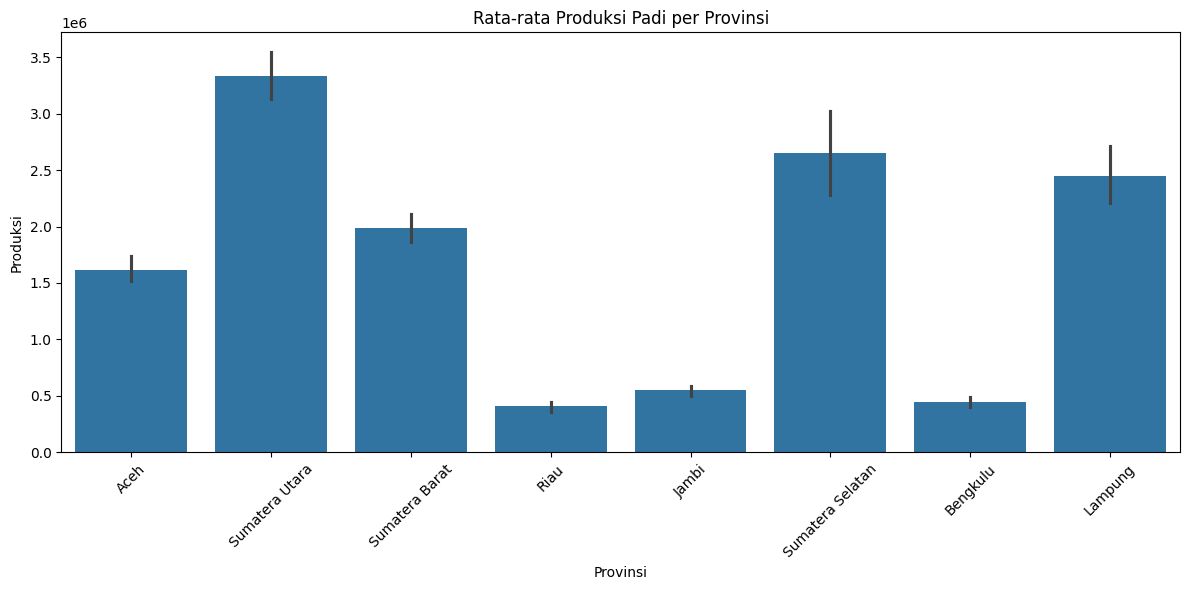

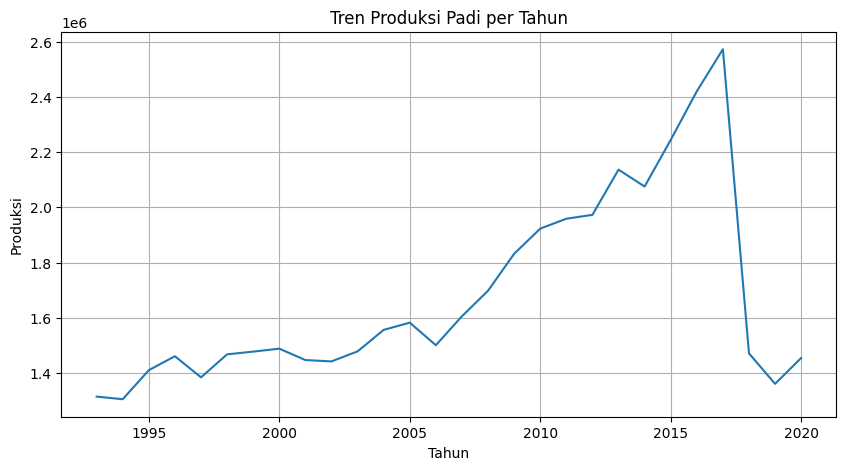

In [41]:
# ============================================================
# EDA (Exploratory Data Analysis)
# ============================================================
# ---------- 1. Info dataset ----------
print("=== INFO DATASET ===")
print(df.info())
print("\n")

# ---------- 2. Missing values ----------
print("=== MISSING VALUES ===")
print(df.isnull().sum())
print("\n")

# ---------- 3. Statistik deskriptif ----------
print("=== STATISTIK DESKRIPTIF ===")
print(df.describe())
print("\n")

# ============================================================
# Visualisasi EDA
# ============================================================

# ---------- 4. Distribusi tiap variabel numerik ----------
numerik = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerik, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribusi: {col}")
plt.tight_layout()
plt.show()
print("\n")

# ---------- 5. Korelasi (Heatmap) ----------
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerik].corr(), annot=True, cmap="Blues", linewidths=0.5)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()
print("\n")

# ---------- 6. Plot Produksi per Provinsi ----------
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Provinsi", y="Produksi", estimator="mean")
plt.xticks(rotation=45)
plt.title("Rata-rata Produksi Padi per Provinsi")
plt.tight_layout()
plt.show()
print("\n")

# ---------- 7. Tren Produksi per Tahun ----------
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.groupby("Tahun")["Produksi"].mean())
plt.title("Tren Produksi Padi per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Produksi")
plt.grid(True)
plt.show()

In [42]:
# ============================================================
# 3. PREPROCESSING
# ============================================================

# Tentukan target
target = "Produksi"
X = df.drop(columns=[target])
y = df[target]

# --- Pisahkan kolom kategorikal & numerik ---
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(exclude=["object"]).columns

# --- One-hot encoding untuk kolom kategorikal ---
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- Standarisasi fitur numerik ---
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

In [43]:
# ============================================================
# 4. TRAIN-TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [44]:
# ============================================================
# 5. MODEL DEFINITIONS
# ============================================================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

In [45]:
# ============================================================
# 6A. TRAINING & EVALUATION — BEFORE TUNING
# ============================================================
hasil_before = []

print("\n=== EVALUASI SEBELUM TUNING ===\n")

for nama, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)

    hasil_before.append([nama, mae, mse, rmse, r2])

df_before = pd.DataFrame(hasil_before, columns=["Model", "MAE", "MSE", "RMSE", "R2"])
print(df_before.sort_values("R2", ascending=False))



=== EVALUASI SEBELUM TUNING ===

               Model            MAE           MSE           RMSE        R2
2            XGBoost  114818.188972  2.591675e+10  160986.816190  0.970687
1      Random Forest  123486.206304  3.061037e+10  174958.196296  0.965378
0  Linear Regression  229035.397856  9.035828e+10  300596.545619  0.897800
3                KNN  223119.837378  9.813773e+10  313269.416092  0.889001


In [46]:
# ============================================================
# 6B. HYPERPARAMETER TUNING (Versi Rapi + Clean Output)
# ============================================================
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import time
start_time = time.time()

print("\n====================================================")
print("HYPERPARAMETER TUNING DIMULAI")
print("====================================================\n")

tuned_models = {}

# ============================================================
# 1. RANDOM FOREST
# ============================================================

print("Tuning Random Forest ...")

rf_param = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]    # diperbaiki (tanpa 'auto')
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param,
    n_iter=20,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=0,
    random_state=42
)
rf_search.fit(X_train, y_train)
tuned_models["Random Forest (Tuned)"] = rf_search.best_estimator_

print("Random Forest tuning selesai")
print("Best Params:", rf_search.best_params_)
print("\n")


# ============================================================
# 2. XGBOOST
# ============================================================

print("Tuning XGBoost ...")

xgb_param = {
    "n_estimators": [200, 300, 400, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.5, 0.7, 1]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param,
    n_iter=20,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=0,
    random_state=42
)
xgb_search.fit(X_train, y_train)
tuned_models["XGBoost (Tuned)"] = xgb_search.best_estimator_

print("XGBoost tuning selesai")
print("Best Params:", xgb_search.best_params_)
print("\n")


# ============================================================
# 3. LINEAR REGRESSION (Ridge/Lasso)
# ============================================================

print("Tuning Linear Regression (Ridge/Lasso) ...")

ridge_param = {"alpha": np.logspace(-3, 3, 20)}
lasso_param = {"alpha": np.logspace(-3, 3, 20)}

ridge_search = RandomizedSearchCV(Ridge(), ridge_param, n_iter=10, cv=3, scoring="r2", random_state=42)
lasso_search = RandomizedSearchCV(Lasso(), lasso_param, n_iter=10, cv=3, scoring="r2", random_state=42)

ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)

if ridge_search.best_score_ > lasso_search.best_score_:
    tuned_models["Linear Regression (Tuned)"] = ridge_search.best_estimator_
    best_linear = ridge_search.best_params_
else:
    tuned_models["Linear Regression (Tuned)"] = lasso_search.best_estimator_
    best_linear = lasso_search.best_params_

print("Linear Regression tuning selesai")
print("Best Params:", best_linear)
print("\n")


# ============================================================
# 4. KNN
# ============================================================

print("Tuning KNN ...")

knn_param = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 20],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

knn_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=knn_param,
    n_iter=15,
    cv=3,
    scoring="r2",
    random_state=42
)

knn_search.fit(X_train, y_train)
tuned_models["KNN (Tuned)"] = knn_search.best_estimator_

print("KNN tuning selesai")
print("Best Params:", knn_search.best_params_)
print("\n")

# ============================================================
# Selesai
# ============================================================

print("====================================================")
print("HYPERTUNING SELESAI")
print("Waktu proses:", round(time.time() - start_time, 2), "detik")
print("====================================================\n")



HYPERPARAMETER TUNING DIMULAI

Tuning Random Forest ...
Random Forest tuning selesai
Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5}


Tuning XGBoost ...
XGBoost tuning selesai
Best Params: {'subsample': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}


Tuning Linear Regression (Ridge/Lasso) ...
Linear Regression tuning selesai
Best Params: {'alpha': np.float64(0.3359818286283781)}


Tuning KNN ...
KNN tuning selesai
Best Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}


HYPERTUNING SELESAI
Waktu proses: 40.03 detik



In [47]:
# ============================================================
# 6C. TRAINING & EVALUATION — AFTER TUNING
# ============================================================
hasil_after = []

print("\n=== EVALUASI SETELAH TUNING ===\n")

for nama, model in tuned_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)

    hasil_after.append([nama, mae, mse, rmse, r2])

df_after = pd.DataFrame(hasil_after, columns=["Model", "MAE", "MSE", "RMSE", "R2"])
print(df_after.sort_values("R2", ascending=False))



=== EVALUASI SETELAH TUNING ===

                       Model            MAE           MSE           RMSE  \
1            XGBoost (Tuned)  102195.232417  2.003593e+10  141548.341377   
0      Random Forest (Tuned)  146850.749497  4.071255e+10  201773.520926   
3                KNN (Tuned)  183246.520712  6.292483e+10  250848.226193   
2  Linear Regression (Tuned)  222868.073126  8.308154e+10  288238.692259   

         R2  
1  0.977338  
0  0.953952  
3  0.928828  
2  0.906030  


In [48]:
# ============================================================
# DICTIONARY MODEL BEFORE TUNING
# ============================================================

models_before = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}


GRAFIK ACTUAL vs PREDIKSI — BEFORE TUNING



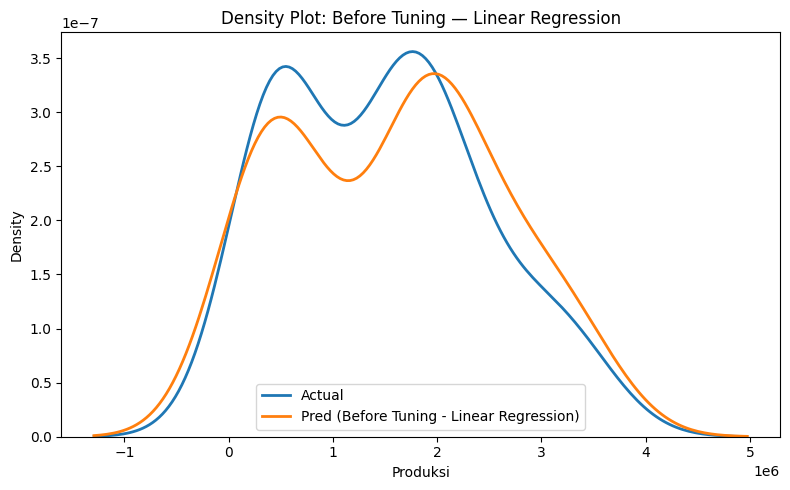

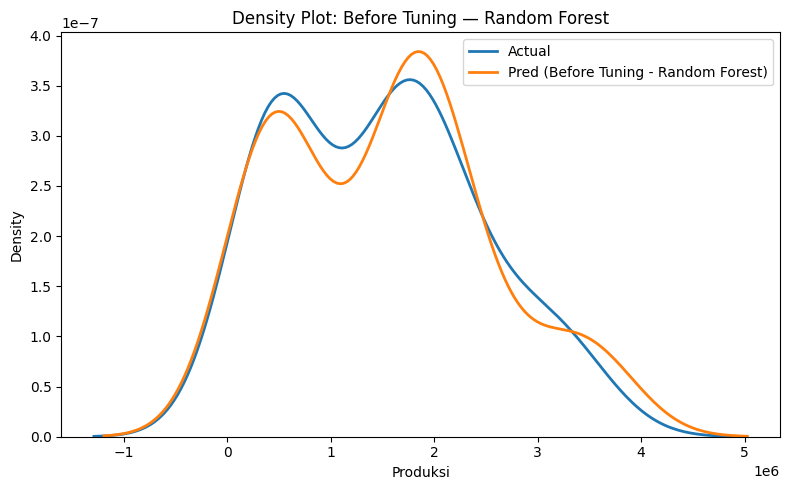

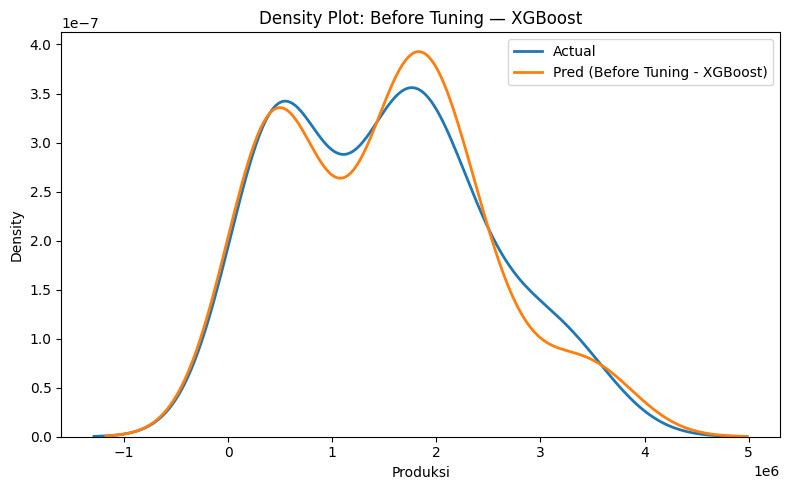

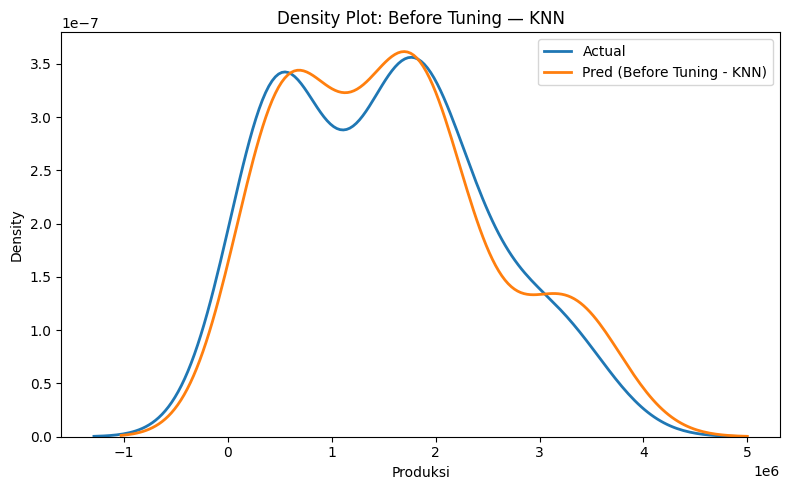

In [52]:
# ============================================================
# 7A. GRAFIK BEFORE TUNING
# ============================================================
print("\n======================================")
print("GRAFIK ACTUAL vs PREDIKSI — BEFORE TUNING")
print("======================================\n")

for nama, model in models_before.items():

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    plt.figure(figsize=(8,5))
    sns.kdeplot(y_test, linewidth=2, label="Actual")
    sns.kdeplot(pred, linewidth=2, label=f"Pred (Before Tuning - {nama})")

    plt.title(f"Density Plot: Before Tuning — {nama}")
    plt.xlabel("Produksi")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\n")


GRAFIK ACTUAL vs PREDIKSI — AFTER TUNING



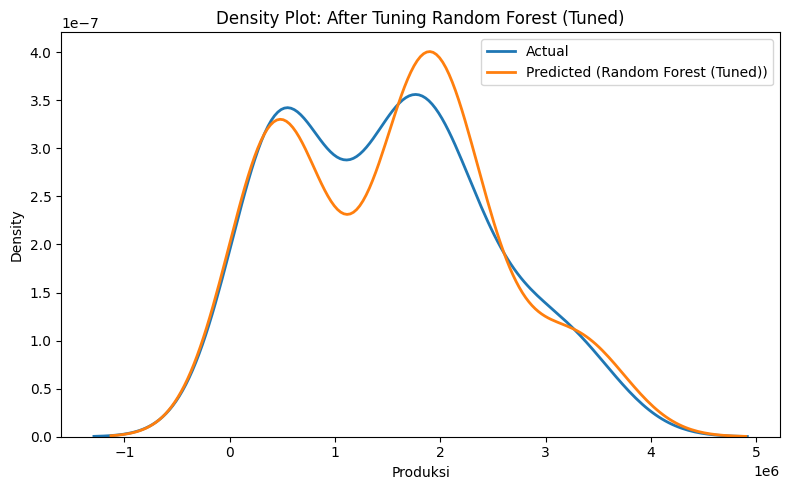

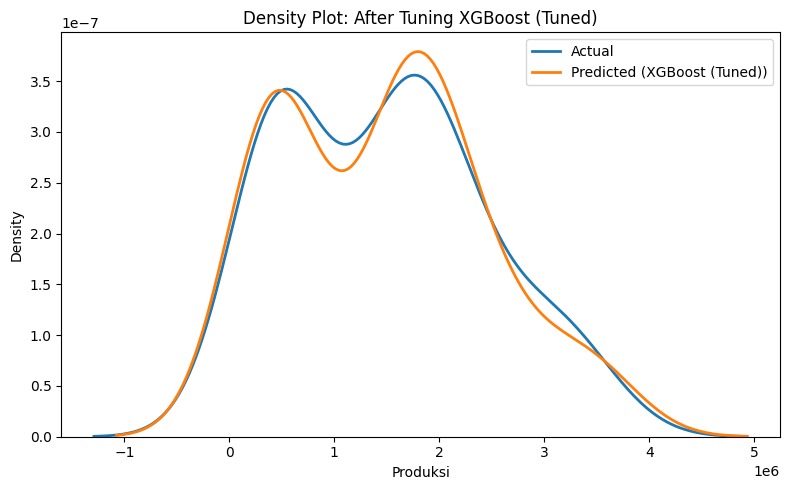

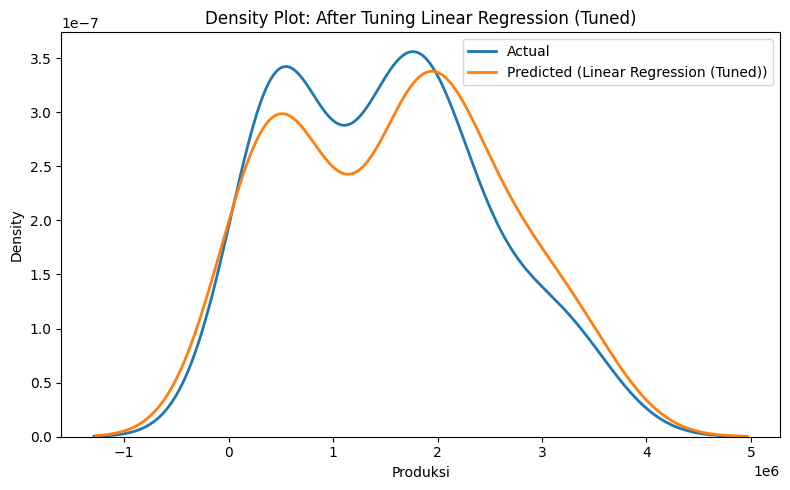

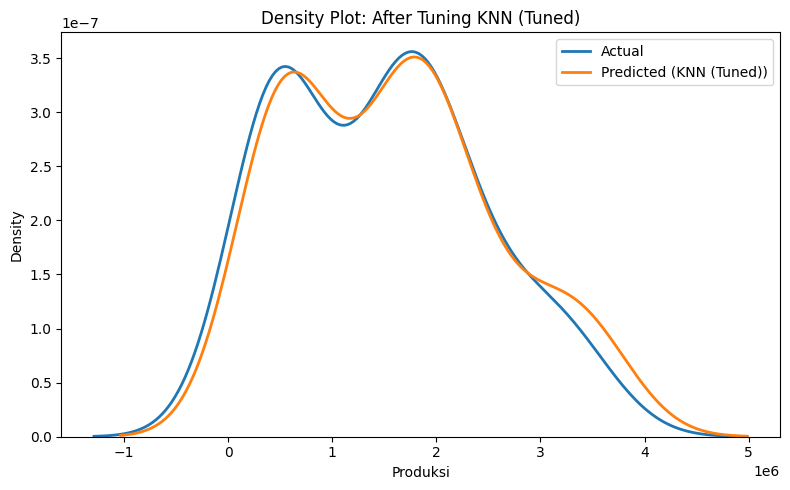

In [54]:
# ============================================================
# 7B. GRAFIK ACTUAL vs PREDIKSI SETELAH TUNING
# ============================================================
print("\n======================================")
print("GRAFIK ACTUAL vs PREDIKSI — AFTER TUNING")
print("======================================\n")

for nama, model in tuned_models.items():

    # pastikan model dilatih
    model.fit(X_train, y_train)

    # prediksi
    pred = model.predict(X_test)

    # plotting
    plt.figure(figsize=(8, 5))
    sns.kdeplot(y_test, linewidth=2, label="Actual")
    sns.kdeplot(pred, linewidth=2, label=f"Predicted ({nama})")

    plt.title(f"Density Plot: After Tuning {nama}")
    plt.xlabel("Produksi")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\n")
